In [166]:
import datajoint as dj
import numpy as np
# Connect to datajoint server
dj.conn()
# Talk to Conrad, get his code onto github

DataJoint connection (connected) alex@ucsd-demo-db.datajoint.io:3306

In [167]:
# Define which schema you're using
schema = dj.schema('common_atlas')

In [189]:
Mouse.drop()
@schema
class Mouse(dj.Manual):
    definition = """
    mouse : char(18)               # Name for lab mouse, max 8 chars
    -------
    date_of_birth  : date          # (date) the mouse's date of birth
    sex            : enum('M','F') # (M/F) either 'M' for male, 'F' for female
    genotype       : varchar(10)   # (Str) indicating the genotype
    weight         : double        # (int) weight of the mouse in grams
    """
@schema
class Injection(dj.Manual): # Change to Perfusion
    definition = """
    -> Mouse                        # One injection per mouse
    injection_number : int          # iterative, how many injections have already been performed
    -------
    injection_date  : date          # (date) what day was the injection performed
    injection_type  : varchar(30)   # (Str) what kind of tracer/injection
    assessment=''   : varchar(1000) # (Str) qualitative assessment of injection
    """
@schema
class Histology(dj.Manual):
    definition = """
    -> Mouse                        # One Histology per injection per mouse
    ------------
    region         : varchar(10)    # (Str)
    thickness      : int            # (int) thickness of each slice in microns
    orientation    : varchar(10)    # (Str)
    counter_stain  : varchar(10)    # (Str)
    """
@schema 
class BrainStackInfo(dj.Manual):
    definition = """
    -> Histology            # One Histology per injection per mouse
    ------------
    stack_name       : varchar(10)   # (Str) unique designation for each mouse
    slides           : int           # (int) number of slides scanned
    sections         : int           # (int) total number of histology slices
    channels         : int           # (int) number of channels for each slice
    
    unique index (stack_name)   # Adds constraint, stack name must be unique accross brains
    """
@schema
class RawStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    """
        
    class Slice(dj.Part):
        definition = """
        -> RawStack
        slice_num : int           # (int) the slice's number
        -----------
        slice_name : varchar(80)  # (Str) the slice's name
        slice_img  : blob         # (Img) the raw slice
        """

    def make(self, key):
        # Making test image
        file = open('sorted_filenames.txt')
        file_list = file.read().split('\n')
        image = np.zeros((100,80))
        
        self.insert1(key)
        RawStack.Slice().insert([
                dict(key, 
                     slice_num = file_list[i][1+file_list[i].index(' '):], 
                     slice_name = file_list[i][:file_list[i].index(' ')], 
                     slice_img=image)
                for i in range(0,len(file_list))  ], 
                    skip_duplicates=True)
@schema
class ProcessedStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    """
        
    class Slice(dj.Part):
        definition = """
        -> ProcessedStack
        slice_num : int           # (int) the slice's number
        -----------
        slice_name : varchar(80)  # (Str) the slice's name
        slice_img  : blob         # (Img) the raw slice
        """

    def make(self, key):
        # Making test image
        file = open('sorted_filenames.txt')
        file_list = file.read().split('\n')
        image = np.ones((100,80))
        
        self.insert1(key)
        ProcessedStack.Slice().insert([
                dict(key, 
                     slice_num = file_list[i][1+file_list[i].index(' '):], 
                     slice_name = file_list[i][:file_list[i].index(' ')], 
                     slice_img=image)
                for i in range(0,len(file_list))  ], 
                    skip_duplicates=True)

`common_atlas`.`mouse` (1 tuples)
`common_atlas`.`injection` (1 tuples)
`common_atlas`.`histology` (1 tuples)
`common_atlas`.`brain_stack_info` (1 tuples)
`common_atlas`.`__raw_stack` (1 tuples)
`common_atlas`.`__raw_stack__slice` (499 tuples)
`common_atlas`.`__processed_stack` (1 tuples)
`common_atlas`.`__processed_stack__slice` (499 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [ ]:
@schema
class Classifier(dj.Manual):
    definition = """
    classifier_id  : int           # 
    -------
    classifier_param_1 : int
    classifier_param_2 : varchar(20)
    """

In [187]:
mouse_name = '2018-0129 04'

Mouse.insert1(dict(mouse=mouse_name,
                   date_of_birth='2017-12-05',
                   sex='M',
                   genotype='C57',
                   weight='24.4')
                 ,skip_duplicates=True)
Injection.insert1(dict(mouse=mouse_name,
                       injection_number=1,
                       injection_date='2018-02-14',
                       injection_type='Ntb',
                       assessment='Good injection.')
                 ,skip_duplicates=True)
Histology.insert1((mouse_name,
                   'brain',
                   '20',
                   'Sagittal',
                   '??')
                 ,skip_duplicates=True)
BrainStackInfo.insert1(dict(mouse=mouse_name,
                            stack_name='UCSD001',
                            slides='125',
                            sections='500',
                            channels=1)
                 ,skip_duplicates=True)
RawStack.populate(  )
ProcessedStack.populate(  )

In [170]:
(Mouse()&dict(mouse=mouse_name)).fetch( )

array([('2018-0129 04', datetime.date(2017, 12, 5), 'M', 'C57')],
      dtype=[('mouse', 'O'), ('date_of_birth', 'O'), ('sex', 'O'), ('genotype', 'O')])

In [51]:
(Injection()&dict(mouse=mouse_name)).fetch()[0]

('2018-0129 04', 'Ntb', 'Good injection.')

In [ ]:
RawStack.Slice()

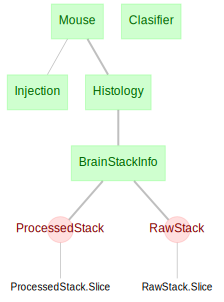

In [190]:
dj.ERD(schema)